<a href="https://colab.research.google.com/github/tejshahi/data_fusion/blob/master/LSTM_train_4band(Nepal_Case).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Import Necessary packages and Read Training data

In [3]:
from osgeo import gdal_array
from osgeo import gdal
import numpy as np
filepath= "/content/drive/MyDrive/dataset_for_fusion/ls_sa_ndvi_training_set_c.dat"
raster = gdal.Open(filepath)
rasterArray = raster.ReadAsArray()
b1 = rasterArray[0,0:rasterArray.shape[1],0:rasterArray.shape[2]]
b2 = rasterArray[1,0:rasterArray.shape[1],0:rasterArray.shape[2]]
b3 = rasterArray[2,0:rasterArray.shape[1],0:rasterArray.shape[2]]
b4 = rasterArray[3,0:rasterArray.shape[1],0:rasterArray.shape[2]]
b5 = rasterArray[4,0:rasterArray.shape[1],0:rasterArray.shape[2]]
b6 = rasterArray[5,0:rasterArray.shape[1],0:rasterArray.shape[2]]

In [4]:
rasterArray.shape

(6, 2661, 3395)

In [5]:
b11=np.reshape(b1,(b1.shape[0]*b1.shape[1],))
b22=np.reshape(b2,(b2.shape[0]*b2.shape[1],))
b33=np.reshape(b3,(b3.shape[0]*b3.shape[1],))
b44=np.reshape(b4,(b4.shape[0]*b4.shape[1],))
b55=np.reshape(b5,(b5.shape[0]*b5.shape[1],))
b66=np.reshape(b6,(b6.shape[0]*b6.shape[1],))

In [6]:
data=np.stack((b11,b33,b55),axis=-1)
target=b22

## Convert data into supervised learning shape

In [7]:
from pandas import DataFrame
from pandas import concat
import pandas as pd

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
n_lag=2
n_feature=3

In [10]:
reframed=series_to_supervised(data,n_lag,1)

In [11]:
reframed.shape

(9034093, 9)

In [12]:
target_y=target[n_lag:]

In [13]:
target_y=target_y.reshape(-1,1)

In [14]:
values = reframed.values

In [15]:
values.shape

(9034093, 9)

In [16]:
n_train = int(values.shape[0] * 0.7)
train_X,train_y = values[:n_train, :],target_y[:n_train]
test_X, test_y = values[n_train:, :], target_y[n_train:]

In [17]:
assert (test_y.size + train_y.size) ==target_y.size

In [18]:
# reshape input to be 3D [samples, timesteps, features]
train_X = np.reshape(train_X, (train_X.shape[0], n_lag+1, n_feature))
test_X = np.reshape(test_X, (test_X.shape[0], n_lag+1, n_feature))

## Design LSTM Network

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.callbacks import EarlyStopping
model = Sequential()
model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                4080      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 4,111
Trainable params: 4,111
Non-trainable params: 0
_________________________________________________________________


In [21]:
from keras.callbacks import EarlyStopping
# fit network
# fit network
import time
train_s_time=time.clock()
#history = model.fit(train_X, train_y, epochs=50, batch_size=1000, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=100, batch_size=1000, validation_data=(test_X, test_y),callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=2, shuffle=False)
print("training time"+str(time.clock()-train_s_time)+'secs.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


Epoch 1/100
6324/6324 - 43s - loss: 0.0017 - val_loss: 0.0011
Epoch 2/100
6324/6324 - 21s - loss: 0.0011 - val_loss: 0.0011
Epoch 3/100
6324/6324 - 22s - loss: 0.0011 - val_loss: 0.0011
Epoch 4/100
6324/6324 - 22s - loss: 0.0011 - val_loss: 0.0010
Epoch 5/100
6324/6324 - 21s - loss: 0.0011 - val_loss: 0.0010
Epoch 6/100
6324/6324 - 21s - loss: 0.0011 - val_loss: 0.0010
Epoch 7/100
6324/6324 - 21s - loss: 0.0011 - val_loss: 0.0010
Epoch 8/100
6324/6324 - 22s - loss: 0.0011 - val_loss: 9.9590e-04
Epoch 9/100
6324/6324 - 21s - loss: 0.0011 - val_loss: 9.7079e-04
Epoch 10/100
6324/6324 - 22s - loss: 0.0010 - val_loss: 9.5565e-04
Epoch 11/100
6324/6324 - 21s - loss: 0.0010 - val_loss: 9.4681e-04
Epoch 12/100
6324/6324 - 22s - loss: 0.0010 - val_loss: 9.4255e-04
Epoch 13/100
6324/6324 - 22s - loss: 0.0010 - val_loss: 9.3445e-04
Epoch 14/100
6324/6324 - 22s - loss: 0.0010 - val_loss: 9.2696e-04
Epoch 15/100
6324/6324 - 21s - loss: 9.9490e-04 - val_loss: 9.2291e-04
Epoch 16/100
6324/6324 - 21s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


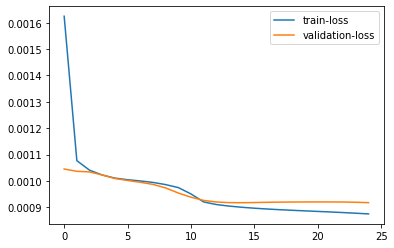

In [ ]:
#plot history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train-loss')
pyplot.plot(history.history['val_loss'], label='validation-loss')
pyplot.legend()
pyplot.show()

### Load testing data for model evaluation (Nepal case)

In [ ]:
filename="/content/drive/My Drive/GIS/ls_sa_ndvi_testing_set_c.dat"
raster = gdal.Open(filename)
rasterArray = raster.ReadAsArray()
tb1 = rasterArray[0,0:rasterArray.shape[1],0:rasterArray.shape[2]]
tb2 = rasterArray[1,0:rasterArray.shape[1],0:rasterArray.shape[2]]
tb3 = rasterArray[2,0:rasterArray.shape[1],0:rasterArray.shape[2]]
tb4 = rasterArray[3,0:rasterArray.shape[1],0:rasterArray.shape[2]]
tb5 = rasterArray[4,0:rasterArray.shape[1],0:rasterArray.shape[2]]
tb6 = rasterArray[5,0:rasterArray.shape[1],0:rasterArray.shape[2]]
tb1_reshape=np.reshape(tb1,(tb1.shape[0]*tb1.shape[1],))
tb3_reshape=np.reshape(tb3,(tb3.shape[0]*tb3.shape[1],))
tb4_reshape=np.reshape(tb4,(tb4.shape[0]*tb4.shape[1],))
tb5_reshape=np.reshape(tb5,(tb5.shape[0]*tb5.shape[1],))
tb6_reshape=np.reshape(tb6,(tb6.shape[0]*tb6.shape[1]))
tb2_reshape=np.reshape(tb2,(tb2.shape[0]*tb2.shape[1],))

In [ ]:
test_data=np.stack((tb1_reshape,tb3_reshape,tb5_reshape),axis=-1)
target=tb2_reshape

In [ ]:
n_lag=2
test_data.shape

(9548280, 3)

In [ ]:
target.shape

(9548280,)

In [ ]:
test_reframed=series_to_supervised(test_data,n_lag,1)

In [ ]:
test_reframed.shape

(9548278, 9)

In [ ]:
test_values=test_reframed.values

In [ ]:
test_y=target[n_lag:]
test_y.shape

(9548278,)

In [ ]:
test_X=test_reframed.values
test_X = np.reshape(test_X, (test_X.shape[0], n_lag+1, n_feature))

In [ ]:
test_X.shape

(9548278, 3, 3)

In [ ]:
#whole test data performance evaluations
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score
pred_y=model.predict(test_X)
print("r2 score: %.6f" %r2_score(test_y,pred_y))
rmse = sqrt(mean_squared_error(test_y,pred_y))
print('Test RMSE: %.3f' % rmse)
# calculate MAE
mae = mean_absolute_error(test_y,pred_y)
print('Test MAE: %.3f' % mae)

r2 score: 0.902372
Test RMSE: 0.037
Test MAE: 0.027


In [ ]:
j=0
case1_x=[]
case1_y=[]
case2_x=[]
case2_y=[]
case3_x=[]
case3_y=[]
case4_x=[]
case4_y=[]
case5_x=[]
case5_y=[]
case6_x=[]
case6_y=[]
case7_x=[]
case7_y=[]
case8_x=[]
case8_y=[]
case9_x=[]
case9_y=[]
for i in range(tb1.size):
    if(tb1_reshape[i]<tb2_reshape[i]<tb3_reshape[i]):
        case1_x.append([tb1_reshape[i],tb3_reshape[i],tb5_reshape[i]])
        case1_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]<tb2_reshape[i]==tb3_reshape[i]):
        case2_x.append([tb1_reshape[i],tb3_reshape[i],tb5_reshape[i]])
        case2_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]<tb2_reshape[i]>tb3_reshape[i]):
        case3_x.append([tb1_reshape[i],tb3_reshape[i],tb5_reshape[i]])
        case3_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]==tb2_reshape[i]<tb3_reshape[i]):
        case4_x.append([tb1_reshape[i],tb3_reshape[i],tb5_reshape[i]])
        case4_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]==tb2_reshape[i]==tb3_reshape[i]):
        case5_x.append([tb1_reshape[i],tb3_reshape[i],tb5_reshape[i]])
        case5_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]==tb2_reshape[i]>tb3_reshape[i]):
        case6_x.append([tb1_reshape[i],tb3_reshape[i],tb5_reshape[i]])
        case6_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]>tb2_reshape[i]<tb3_reshape[i]):
        case7_x.append([tb1_reshape[i],tb3_reshape[i],tb5_reshape[i]])
        case7_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]>tb2_reshape[i]==tb3_reshape[i]):
        case8_x.append([tb1_reshape[i],tb3_reshape[i],tb5_reshape[i]])
        case8_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]>tb2_reshape[i]>tb3_reshape[i]):
        case9_x.append([tb1_reshape[i],tb3_reshape[i],tb5_reshape[i]])
        case9_y.append(tb2_reshape[i])

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score
def predict_case(x,y):
    pred_y=model.predict(x)
    print("r2 score %",r2_score(y,pred_y))
    rmse = sqrt(mean_squared_error(y,pred_y))
    print('Test RMSE: %.3f' % rmse)
    # calculate MAE
    mae = mean_absolute_error(y,pred_y)
    print('Test MAE: %.3f' % mae)
    return(pred_y)

In [ ]:
def prepare_case(case1_x,case1_y):
  a=np.array(case1_x)
  b=np.array(case1_y)
  assert a.shape[0]==b.shape[0]
  case1_x_data=series_to_supervised(a,n_lag,1)
  y=b[n_lag:]
  case1_x_data=case1_x_data.values
  x = np.reshape(case1_x_data, (case1_x_data.shape[0], n_lag+1, n_feature))
  return (x,y)

In [ ]:
x,y=prepare_case(case1_x,case1_y)
y1=predict_case(x,y)

r2 score % 0.8596690172710877
Test RMSE: 0.036
Test MAE: 0.027


In [ ]:
x,y=prepare_case(case3_x,case3_y)
y3=predict_case(x,y)

r2 score % 0.8322454841536511
Test RMSE: 0.068
Test MAE: 0.046


In [ ]:
x,y=prepare_case(case7_x,case7_y)
y7=predict_case(x,y)
x,y=prepare_case(case9_x,case9_y)
y9=predict_case(x,y)

r2 score % 0.882399247895487
Test RMSE: 0.040
Test MAE: 0.030
r2 score % 0.9548146295429182
Test RMSE: 0.042
Test MAE: 0.031


### Save the Trained Model for later uses

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("LSTM-model-band4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("LSTM-model-band4.h5")
print("Saved model to disk")

Saved model to disk
